##### Copyright 2019 The TensorFlow Authors.

# Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [1]:
#TODO: import tensorflow
import tensorflow as tf


from tensorflow.keras import datasets, layers, models, regularizers

#TODO: import matplotlib
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
#TODO: Load cifar10 dataset into train and test
(train_images, train_labels ), (test_images , test_labels ) = datasets.cifar10.load_data()



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255 , test_images / 255

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


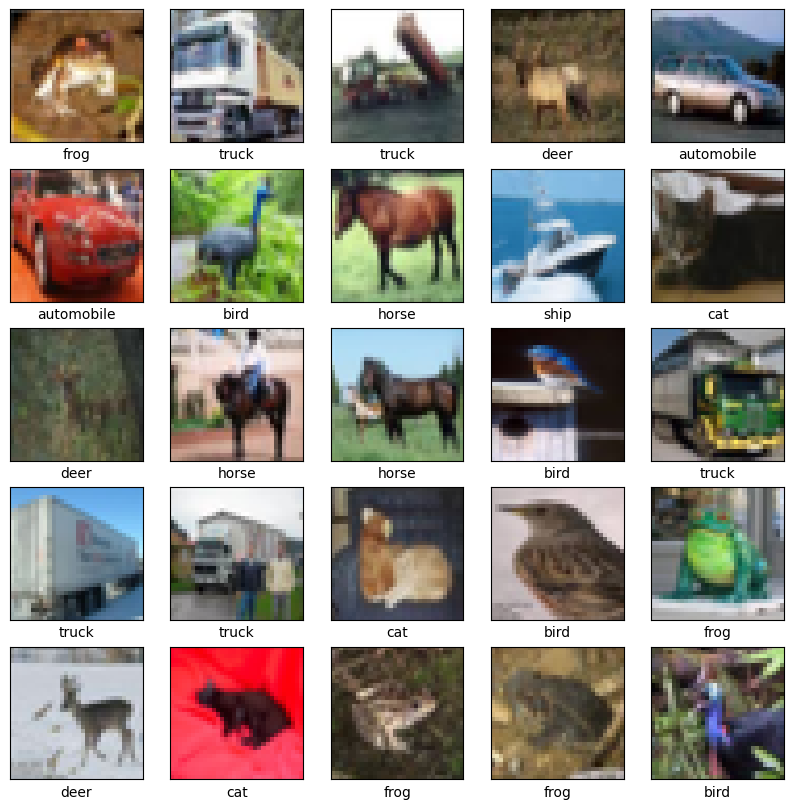

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


#TODO: create a fig of size (10,10)
plt.figure(figsize=(10,10))


for i in range(25) : #TODO: loop over 25 images
    plt.subplot(5,5, i+1 ) #todo: create a subplot of size 5,5
    plt.xticks([])
    plt.yticks([])
    plt.grid(False) #dont show the grid
    plt.imshow(train_images[i]) #todo: plot the image of index i of the training set
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]]) #todo: add the class name of the image of index i
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [5]:
#Use Keras Sequential API

model = models.Sequential() #TODO: init keras sequential
#TODO: add Convolution 2d layer, with 32 neurons, and size of kernel 3,3, activation function relu
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))#input shape is the size of the images
#TODO: add a Maxpooling 2d layer
model.add(layers.AveragePooling2D((2,2)))
#TODO: add another conv2d layer, but increase size of neurons following the powers of 2 -> 64
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
#TODO: Another Maxpooling layer
model.add(layers.MaxPooling2D(pool_size=(1,1)))
#TODO: Last Conv2d lauer
model.add(layers.Conv2D(128,(3,3),activation='relu'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of your model so far:

In [6]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,504 (365.25 KB)

 Trainable params: 93,376 (364.75 KB)

 Non-trainable params: 128 (512.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [7]:
from threading import active_count
#TODO: Flatten the output
model.add(layers.Flatten())
#TODO: add two dense layers
model.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax')) #TODO: Pay attention to the number of neurons here, its the output layer

Here's the complete architecture of your model:

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         991,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089,610 (4.16 MB)

 Trainable params: 1,089,482 (4.16 MB)

 Non-trainable params: 128 (512.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

In [10]:
#TODO: Choose adam optimizer and the correct loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(train_images, train_labels),epochs=15,
                    validation_data=(test_images, test_labels),verbose=True)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - accuracy: 0.3667 - loss: 1.8052 - val_accuracy: 0.5374 - val_loss: 1.3838
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - accuracy: 0.5421 - loss: 1.3746 - val_accuracy: 0.5622 - val_loss: 1.3574
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.5928 - loss: 1.2648 - val_accuracy: 0.6541 - val_loss: 1.1283
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.6299 - loss: 1.1876 - val_accuracy: 0.6676 - val_loss: 1.1222
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6470 - loss: 1.1381 - val_accuracy: 0.6895 - val_loss: 1.0639
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.6684 - loss: 1.0984 - val_accuracy: 0.6862 - val_loss: 1.0490
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6759 - loss: 1.0736 - val_accuracy: 0.6010 - val_loss: 1.4341
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6884 - loss: 1.04

### Evaluate the model

313/313 - 1s - 2ms/step - accuracy: 0.7338 - loss: 0.9376


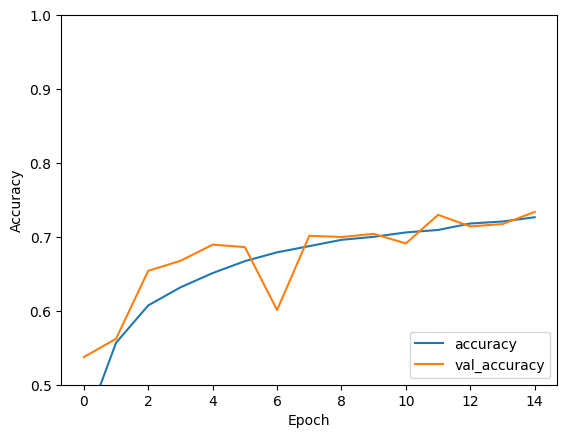

In [14]:
#TODO: Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'] , label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels , verbose=2)

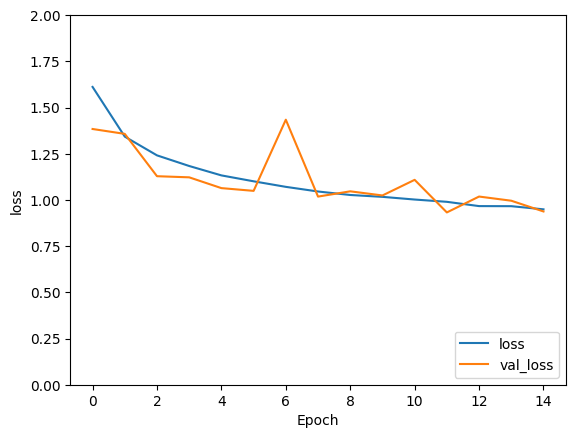

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'] , label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [18]:
print(f"test accuracy is : {test_acc:}")
print(f"test loss is : {test_loss}")

test accuracy is : 0.7337999939918518
test loss is : 0.9375928640365601


In [20]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
def prepare_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input
    img_array = tf.expand_dims(img_array, 0)
    # Preprocess the image
    img_array = preprocess_input(img_array)
    return img_array

In [21]:
def predict_image(img_path, model):
    target_size = (32, 32)  # Adjust this to match your model's expected input size
    img_array = prepare_image(img_path, target_size)
    # Make prediction
    predictions = model.predict(img_array)
    return predictions

In [26]:
import numpy as np
predictions = predict_image("horse.jpg", model)
print(class_names[np.argmax(predictions[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
horse


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.